In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os
import numpy as np                      # type: ignore
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import seaborn as sns                   # type: ignore
import cv2                              # type: ignore
import torch                            # type: ignore
import yaml                             # type: ignore
from PIL import Image                   # type: ignore
from ultralytics import YOLO            # type: ignore
from IPython.display import Video       # type: ignore

> ## **Loading the YOLOv8 Model** 🚀

In [2]:
model = YOLO('yolov8n.pt')

In [19]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

> ## **YAML File Validation** 📁
The code checks if the YAML file exists at the specified path, loads its contents, and prints the data in a readable format. It is typically used for loading configuration files or dataset information stored in YAML format.

In [3]:
dataset_path = 'Dataset'                                    # Ensure the dataset_path is correctly set
yaml_file_path = os.path.join(dataset_path, 'data.yaml')    # Ensure the yaml_file_path is correctly set

if not os.path.exists(yaml_file_path):
    raise FileNotFoundError(f"YAML file not found at: {yaml_file_path}")

with open(yaml_file_path, 'r') as file:                     # Load and print the contents of the YAML file in readable format
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: G:\# Data Science\projects\04 DL\Dataset\train\images
val: G:\# Data Science\projects\04 DL\Dataset\valid\images



> ## **Image Analysis for Training and Validation Sets** 🔍
The code analyzes images in training and validation folders to count them and check if they share the same dimensions or vary, using the PIL library with error handling

In [4]:
train_images_path = os.path.join(dataset_path, 'train', 'images')  
valid_images_path = os.path.join(dataset_path, 'valid', 'images') 

def analyze_images(folder_path):                # Function to analyze images in a folder
    if not os.path.exists(folder_path):  
        raise FileNotFoundError(f"Folder not found: {folder_path}")   
    
    num_images = 0                              # Initialize the number of images
    image_sizes = set()                         # Set to store unique image sizes
    
    for filename in os.listdir(folder_path):    
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):    # Check if the file is an image with a supported format
            num_images += 1          
            image_path = os.path.join(folder_path, filename)  
            try:
                with Image.open(image_path) as img:  
                    image_sizes.add(img.size)                       # Add the image dimensions (width, height) to the set to track unique image sizes
            except Exception as e: 
                print(f"Error loading image {filename}: {e}")  
    
    return num_images, image_sizes  

################## Analyze training images ##################
num_train_images, train_image_sizes = analyze_images(train_images_path)             
print(f"Number of training images: {num_train_images}")  
if len(train_image_sizes) == 1:                                                     # Check if all images have the same size
    print(f"All training images have the same size: {train_image_sizes.pop()}")  
else:
    print("Training images have varying sizes.") 
################## Analyze validation images ##################
num_valid_images, valid_image_sizes = analyze_images(valid_images_path)
print(f"Number of validation images: {num_valid_images}")  
if len(valid_image_sizes) == 1:                                                     # Check if all images have the same size
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")   
else:
    print("Validation images have varying sizes.")  

Number of training images: 536
All training images have the same size: (640, 640)
Number of validation images: 90
All validation images have the same size: (640, 640)


> ## **Model Training Configuration** 🚀
Training the YOLO model on a custom dataset with defined parameters to optimize performance and prevent overfitting through techniques like early stopping and dropout regularization.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# Train the model on our custom dataset
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=10,               # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    device=device,           
    patience=50,             # Epochs to wait for no observable improvement for early stopping of training
    batch=16,                # Number of images per batch
    optimizer='Adam',        # Optimizer to use
    lr0=0.001,               # Initial learning rate 
    lrf=0.1,                 # Final learning rate (lr0 * lrf)
    dropout=0.2,             # Use dropout regularization
    seed=0,                  # Random seed for reproducibility
    workers=2                # Number of DataLoader workers
)
## to avoid errors >> go to Dataset/data.yaml and change path to images and labels

engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Dataset\data.yaml, epochs=10, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic

train: Scanning G:\# Data Science\projects\04 DL\Dataset\train\labels.cache... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:00<?, ?it/s]
val: Scanning G:\# Data Science\projects\04 DL\Dataset\valid\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.98G      1.246      1.777       1.02         53        640: 100%|██████████| 34/34 [03:04<00:00,  5.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.22s/it]

                   all         90        937     0.0303      0.874      0.711      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.02G      1.169      0.908      1.025         69        640: 100%|██████████| 34/34 [03:11<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.01s/it]

                   all         90        937      0.776      0.798      0.835      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.01G      1.124     0.8036      1.016        113        640: 100%|██████████| 34/34 [03:10<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.92s/it]

                   all         90        937      0.836      0.868      0.915      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.04G      1.093      0.747     0.9928        108        640: 100%|██████████| 34/34 [03:11<00:00,  5.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.90s/it]

                   all         90        937      0.837      0.901      0.936       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.01G      1.074     0.7146     0.9865         66        640: 100%|██████████| 34/34 [03:08<00:00,  5.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.05s/it]

                   all         90        937      0.891      0.883      0.949      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.03G      1.051     0.6847     0.9808         63        640: 100%|██████████| 34/34 [03:02<00:00,  5.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.82s/it]

                   all         90        937      0.898      0.913      0.958      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.02G      1.037     0.6593     0.9694         58        640: 100%|██████████| 34/34 [03:01<00:00,  5.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]

                   all         90        937      0.881      0.909      0.954      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.02G      1.017     0.6218     0.9617        116        640: 100%|██████████| 34/34 [03:06<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.79s/it]

                   all         90        937      0.924      0.903      0.965      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.96G      1.001     0.6177      0.958        112        640: 100%|██████████| 34/34 [03:05<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]

                   all         90        937      0.879      0.935      0.961      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.02G     0.9867     0.5888     0.9536         64        640: 100%|██████████| 34/34 [03:03<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]

                   all         90        937      0.889      0.924      0.965       0.71



10 epochs completed in 0.575 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.55  Python-3.12.4 torch-2.4.1 CUDA:0 (Quadro M1000M, 2048MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


                   all         90        937      0.889      0.924      0.965      0.711
Speed: 1.9ms preprocess, 76.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train


> ## **Post-Training Files Listing** 📂
Listing all files generated during the model's training process, such as results, logs, and saved weights, from the specified directory.

In [7]:
# Define the path to the directory
post_training_files_path = r'runs\detect\train'

for file_name in os.listdir(post_training_files_path): 
    print(file_name)

args.yaml
confusion_matrix.png
confusion_matrix_normalized.png
events.out.tfevents.1735585815.Azzoz.17040.0
F1_curve.png
labels.jpg
labels_correlogram.jpg
PR_curve.png
P_curve.png
results.csv
results.png
R_curve.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
weights


> ## **Plotting Learning Curves** 📊
Visualizing the learning curves for various loss metrics (`box loss`, `classification loss`, and `distribution focal loss`) to track model performance during training and validation over epochs.

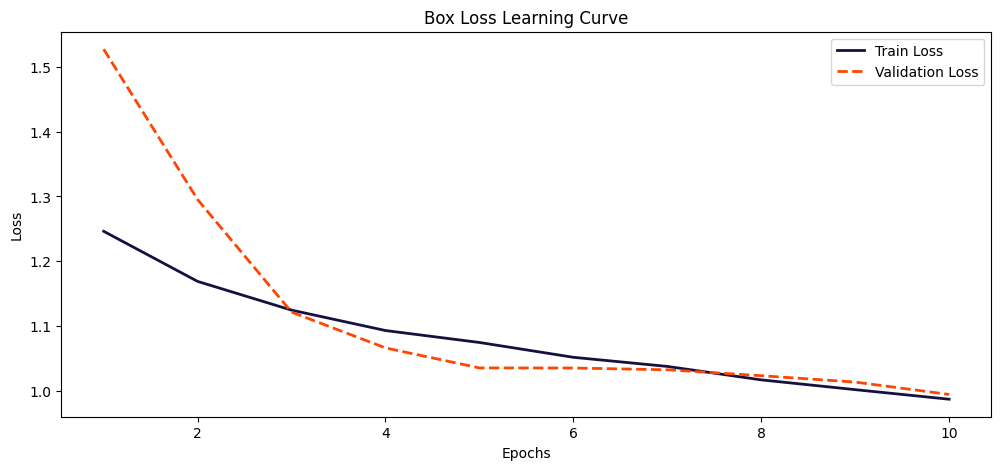

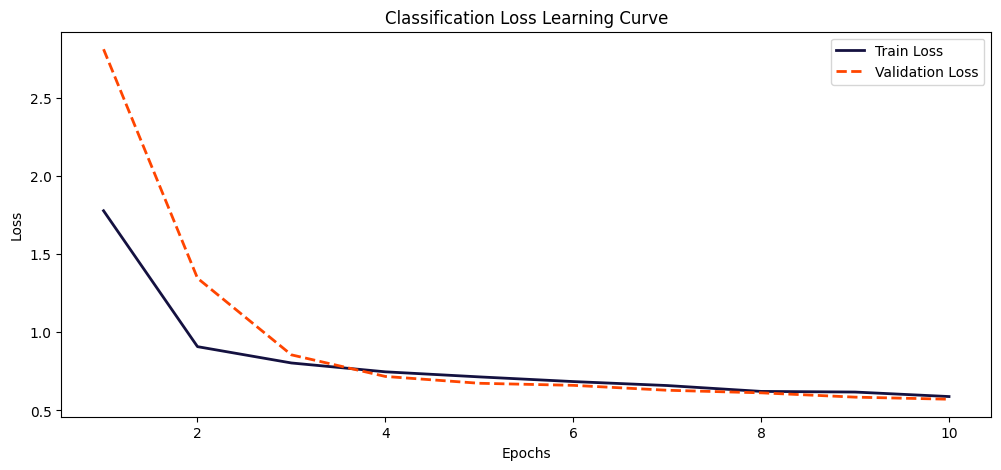

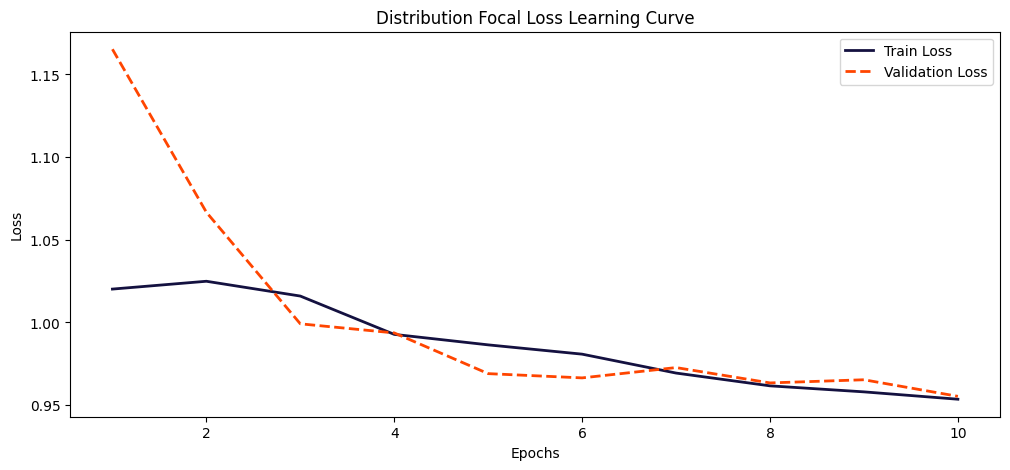

In [8]:
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

file_path = "./runs/detect/train/results.csv"

if not os.path.exists(file_path):       # Check if the file exists
    raise FileNotFoundError(f"The file {file_path} does not exist.")

df = pd.read_csv(file_path)             # Load the CSV file from the constructed path into a pandas DataFrame
df.columns = df.columns.str.strip()     # Remove any leading whitespace from the column names

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

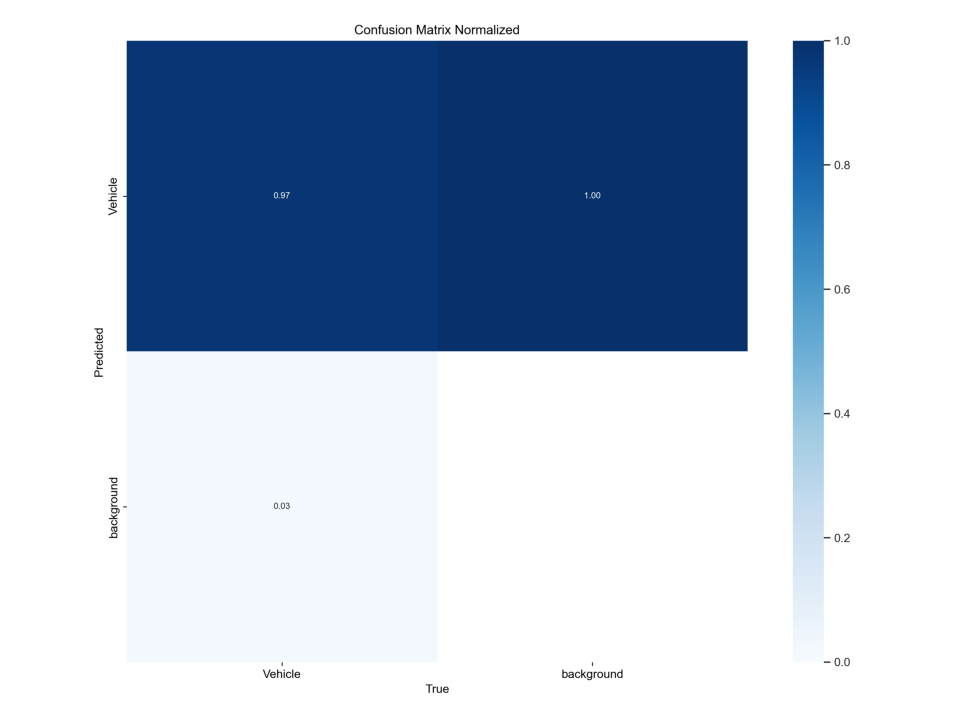

In [9]:
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')
cm_img = cv2.imread(confusion_matrix_path)
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)        # Convert the image from BGR to RGB color space for accurate color representation with matplotlib

plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off') 
plt.show()

> ## **Loading and Validating the Best Model** 🏆
Loading the best-performing model weights and evaluating it on the validation set to assess its performance based on predefined metrics.

In [10]:
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')
best_model = YOLO(best_model_path)

In [11]:
metrics = best_model.val(split='val')       # Validate the best model using the validation set with default parameters

Ultralytics 8.3.55  Python-3.12.4 torch-2.4.1 CUDA:0 (Quadro M1000M, 2048MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning G:\# Data Science\projects\04 DL\Dataset\valid\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.51s/it]


                   all         90        937      0.889      0.925      0.965      0.712
Speed: 3.2ms preprocess, 77.8ms inference, 0.1ms loss, 7.9ms postprocess per image
Results saved to runs\detect\val


> ## **Model Evaluation Metrics** 📊
- **Precision**:  
  The accuracy of the model in identifying the correct objects compared to the total predicted objects.

- **Recall**:  
  The model's ability to retrieve all correct objects from the set of actual objects.

- **mAP50**:  
  The average precision of objects detected with an Intersection over Union (IoU) threshold of 50%.

- **mAP50-95**:  
  The average precision for various IoU thresholds (from 50% to 95%) to evaluate the model's performance across different levels of overlap.

- **Fitness**:  
  Reflects the overall quality of the model's performance and generalization.

In [12]:
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])     # Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df.round(3)     # Round the values to 3 decimal places

Metric Value
metrics/precision(B)         0.889
metrics/recall(B)            0.925
metrics/mAP50(B)             0.965
metrics/mAP50-95(B)          0.712
fitness                      0.737

> ## **Traffic Density Analysis Script** 🚗
- #### This script processes a video to detect and analyze vehicle traffic in two lanes (left and right).           
- #### It uses the YOLO model to count vehicles in each lane and determine the traffic intensity (either "Smooth" or "Heavy") based on a threshold. 
- #### It then annotates the video frames with this information and outputs the processed video.

In [13]:
heavy_traffic_threshold = 10    # thr for the number of cars as heavy or smooth traffic

vertices_left  = np.array([(465, 350), (609, 350), (510, 630), (2, 630)], dtype=np.int32)        # ROI for the left  lane
vertices_right = np.array([(678, 350), (815, 350), (1203, 630), (743, 630)], dtype=np.int32)     # ROI for the right lane

x1, x2 = 325, 635               # this is the top and bottom region to be hidden not interested
lane_threshold = 609            # this is the threshold to determine the lane of the car in {left or right}

In [14]:
text_position_left_lane  = (10, 50)
text_position_right_lane = (820, 50)
intensity_position_left_lane  = (10, 100)
intensity_position_right_lane = (820, 100)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)    # White color for text
background_color = (0, 0, 255)  # Red background for text

In [15]:
cap    = cv2.VideoCapture('./Dataset/sample_video.mp4')     # Load the video file
fourcc = cv2.VideoWriter_fourcc(*'XVID')                    # XVID codec for AVI format, there are other codecs like H264 ,DIVX, etc.
out    = cv2.VideoWriter('traffic_density_analysis.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))
##    >> cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor=None) <<    ##

In [20]:
while cap.isOpened():           # Read until video is completed
    ret, frame = cap.read()     # Capture frame-by-frame
    if ret:
        detection_frame = frame.copy()
        detection_frame[:x1, :] = 0  # Black out top region
        detection_frame[x2:, :] = 0  # Black out bottom region
        
        ###################### Perform object detection ######################
        results = best_model.predict(detection_frame, imgsz=640, conf=0.4)
        processed_frame = results[0].plot(line_width=1)
        # Restore original top and bottom parts : to display the region of interest
        processed_frame[:x1, :] = frame[:x1, :].copy()
        processed_frame[x2:, :] = frame[x2:, :].copy()        
        
        ###################### Draw Region of interest ######################
        cv2.polylines(processed_frame, [vertices_left], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(processed_frame, [vertices_right], isClosed=True, color=(255, 0, 0), thickness=2)
        # Retrieve the bounding boxes from the results
        bounding_boxes = results[0].boxes
        
        ###################### Count vehicles ######################
        vehicles_in_left_lane = 0
        vehicles_in_right_lane = 0
        for box in bounding_boxes.xyxy:
            if box[0] < lane_threshold:     # Check if the vehicle is in the left lane based on the x-coordinate of the bounding box
                vehicles_in_left_lane += 1
            else:
                vehicles_in_right_lane += 1
        
        traffic_intensity_left  = "Heavy" if vehicles_in_left_lane > heavy_traffic_threshold else "Smooth"       # Determine the traffic intensity for the left lane
        traffic_intensity_right = "Heavy" if vehicles_in_right_lane > heavy_traffic_threshold else "Smooth"      # Determine the traffic intensity for the right lane
        
        cv2.rectangle(processed_frame, (text_position_left_lane[0]-10, text_position_left_lane[1] - 25), 
                    (text_position_left_lane[0] + 460, text_position_left_lane[1] + 10), background_color, -1)                  # Add a background rectangle for the left lane vehicle count
        cv2.rectangle(processed_frame, (intensity_position_left_lane[0]-10, intensity_position_left_lane[1] - 25), 
                    (intensity_position_left_lane[0] + 460, intensity_position_left_lane[1] + 10), background_color, -1)        # Add a background rectangle for the left lane traffic intensity
        cv2.rectangle(processed_frame, (text_position_right_lane[0]-10, text_position_right_lane[1] - 25), 
                    (text_position_right_lane[0] + 460, text_position_right_lane[1] + 10), background_color, -1)                # Add a background rectangle for the right lane vehicle count
        cv2.rectangle(processed_frame, (intensity_position_right_lane[0]-10, intensity_position_right_lane[1] - 25), 
                    (intensity_position_right_lane[0] + 460, intensity_position_right_lane[1] + 10), background_color, -1)      # Add a background rectangle for the right lane traffic intensity
        
        cv2.putText(processed_frame, f'Vehicles in Left Lane: {vehicles_in_left_lane}', text_position_left_lane, 
                    font, font_scale, font_color, 2, cv2.LINE_AA)                                                               # Add the {vehicle count text} on {top of the rectangle} for the {left lane}
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_left}', intensity_position_left_lane,          
                    font, font_scale, font_color, 2, cv2.LINE_AA)                                                               # Add the {traffic intensity text} on {top of the rectangle} for the {left lane}
        cv2.putText(processed_frame, f'Vehicles in Right Lane: {vehicles_in_right_lane}', text_position_right_lane, 
                    font, font_scale, font_color, 2, cv2.LINE_AA)                                                               # Add the {vehicle count text} on {top of the rectangle} for the {right lane}
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_right}', intensity_position_right_lane, 
                    font, font_scale, font_color, 2, cv2.LINE_AA)                                                               # Add the {traffic intensity text} on {top of the rectangle} for the {right lane}
        out.write(processed_frame)
    
    else:
        break

###################### to avoid memory leaks ######################
cap.release()
out.release()

> ## **AVI to MP4 Converter Script** 🎬
- #### Simply provide the input `.avi` file and specify the desired `.mp4` output file, and the script takes care of the rest.


In [17]:
import subprocess
def convert_avi_to_mp4(input_file, output_file):
    try:
        # FFmpeg command
        command = [
            "ffmpeg",
            "-i", input_file,   # Input file
            output_file         # Output file
        ]
        # Run the command
        subprocess.run(command, check=True)
        print(f"Conversion successful: {output_file}")
    except subprocess.CalledProcessError as e:
        print("Error during conversion:", e)

input_file  = "traffic_density_analysis.avi" 
output_file = "traffic_density_analysis.mp4"  
convert_avi_to_mp4(input_file, output_file)

Conversion successful: traffic_density_analysis.mp4


In [18]:
Video("traffic_density_analysis.mp4", embed=True, width=960)

<div style="background-color: black; color:rgb(163, 52, 52); width: 100%; height: 50px; text-align: center; font-weight: bold; line-height: 50px; margin: 10px 0; font-size: 50px;">
Thanks 🫡
</div>